<center> <img src="https://www.ufrn.br/resources/documentos/identidadevisual/brasao/brasao_flat.png" width="100" height="100"> </center>

# **<center> PROCESSAMENTO DE LINGUAGEM NATURAL - AMAZON DATASET <center>**
    
---

**Disciplina:** Tópicos Especiais em Inteligência Artificial

**Docente:** José Alfredo

**Discentes:**
* [Douglas Wilian](https://github.com/Douglas-Wilian)
* [Roger José](https://github.com/rogerdox)

In [1]:
#Carregamento das bibliotecas

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from tensorflow.keras import models, layers, optimizers, Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.utils import Sequence
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
import os
import bz2
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


In [2]:
#Importação e separação dos dados

train = bz2.BZ2File('/kaggle/input/amazonreviews/train.ft.txt.bz2')
test = bz2.BZ2File('/kaggle/input/amazonreviews/test.ft.txt.bz2')

def load_extract(file):
    texts, labels = [], [] 
    for line in file:
        x = line.decode('utf-8')
        labels.append(int(x[9]) - 1)
        texts.append(x[10:].strip())
    print('Done !')
    return np.array(labels), texts

ytrain, xtrain = load_extract(train)
ytest, xtest = load_extract(test)

Done !
Done !


In [3]:
#Visualização dos textos

dfdata = pd.DataFrame(xtrain)
dflabel = pd.DataFrame(ytrain)
display(dfdata)
display(dflabel)
xtrain[0]

,0
0,Stuning even for the non-gamer: This sound tra...
1,The best soundtrack ever to anything.: I'm rea...
2,Amazing!: This soundtrack is my favorite music...
3,Excellent Soundtrack: I truly like this soundt...
4,"Remember, Pull Your Jaw Off The Floor After He..."
...,...
3599995,Don't do it!!: The high chair looks great when...
3599996,"Looks nice, low functionality: I have used thi..."
3599997,"compact, but hard to clean: We have a small ho..."
3599998,what is it saying?: not sure what this book is...


,0
0,1
1,1
2,1
3,1
4,1
...,...
3599995,0
3599996,0
3599997,0
3599998,0


'Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'

#### PROCESSAMENTO E LIMPEZA DOS TEXTOS

In [4]:
#Remoção de caracteres indesejados, stopwords e substituição por espaços

def clean_texts(texts):
    stwords = stopwords.words('english')
    temp_texts = []
    for i in range(len(texts)):
        text = re.sub('\d','0',texts[i])
        if 'www.' in text or 'http:' in text or 'https:' in text or '.com' in text: # remoçao de links e urls
            text = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", " ", text)
        
        text = re.sub('[^a-zA-Z]', ' ', text)# Tudo que não é um caractere é substituido por um espaço
        text = text.lower()
        text = text.split()
        text = [word for word in text if not word in stwords] # Remoção das stopwords (for, it, this, etc) 
        text = ' '.join(text)
        temp_texts.append(text)
    return temp_texts


xtrain = clean_texts(xtrain)
xtest = clean_texts(xtest)

print(xtrain[0])

stuning even non gamer sound track beautiful paints senery mind well would recomend even people hate vid game music played game chrono cross games ever played best music backs away crude keyboarding takes fresher step grate guitars soulful orchestras would impress anyone cares listen


#### TOKENIZAÇÃO DOS TEXTOS E TREINAMENTO DO MODELO

In [5]:
# Tokenização e preenchimento dos dados de treino
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(xtrain)
xtrain_seq = tokenizer.texts_to_sequences(xtrain)
xtrain_padded = pad_sequences(xtrain_seq, maxlen=100)

# Tokenização e preenchimento dos dados de teste
xtest_seq = tokenizer.texts_to_sequences(xtest)
xtest_padded = pad_sequences(xtest_seq, maxlen=100)

# Construção do modelo
model = Sequential()
model.add(Embedding(input_dim=1000, output_dim=128, input_length=100))
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Treinamento
history = model.fit(xtrain_padded, ytrain, epochs=1, batch_size=32, validation_split=0.2)

# Avaliação do modelo
loss, accuracy = model.evaluate(xtest_padded, ytest)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

12500/12500 [==============================] - 288s 23ms/step - loss: 0.2581 - accuracy: 0.8915
Test Accuracy: 89.15%


In [6]:
ypred = model.predict(xtest_padded)
ypred

12500/12500 [==============================] - 260s 21ms/step


array([[0.98531973],
       [0.9981155 ],
       [0.00344629],
       ...,
       [0.05590167],
       [0.99110794],
       [0.06243791]], dtype=float32)

In [11]:
ypred_binary = (ypred > 0.5).astype(int)

accuracy = accuracy_score(ytest, ypred_binary)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 89.15%


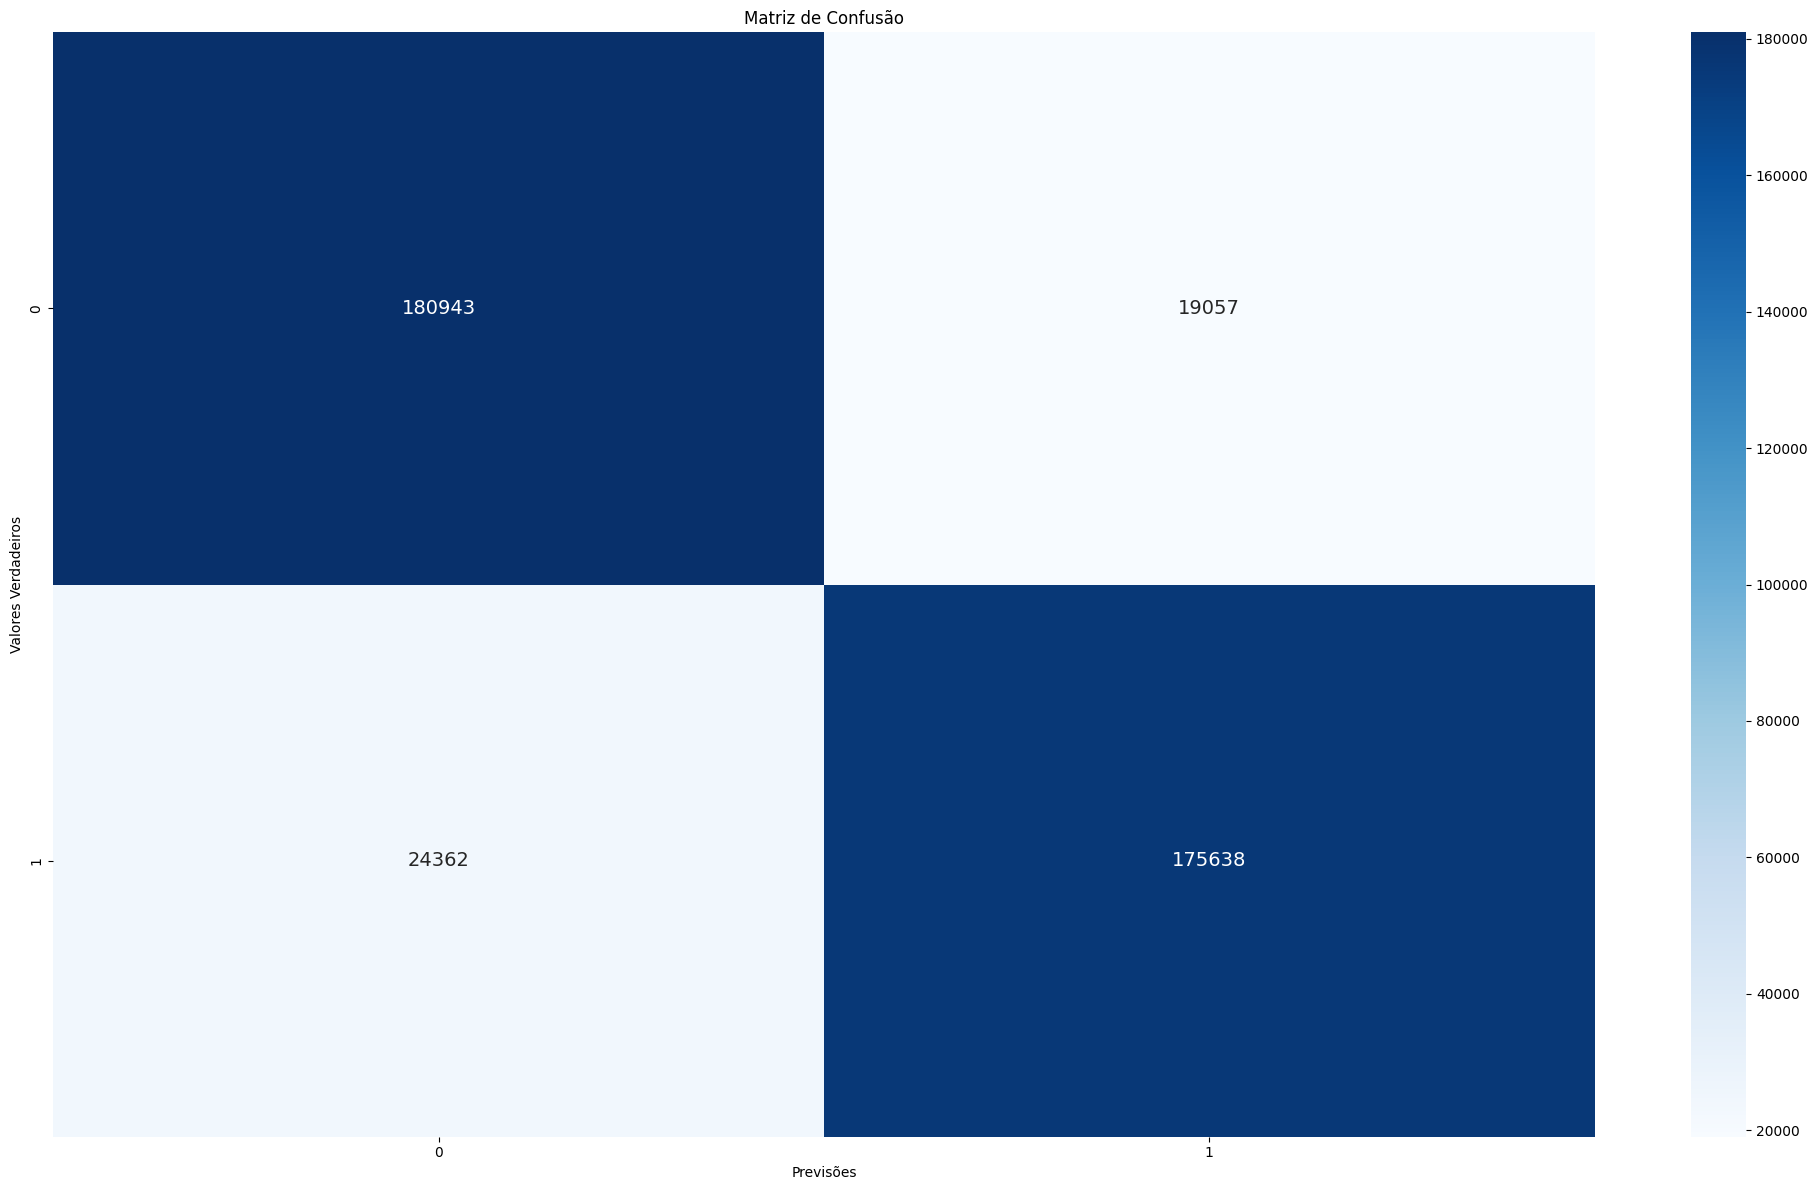

In [12]:
cm = confusion_matrix(ytest, ypred_binary)

plt.figure(figsize=(20, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 14})
plt.xlabel('Previsões')
plt.ylabel('Valores Verdadeiros')
plt.title('Matriz de Confusão')
plt.tight_layout()
plt.savefig('Matriz de confusão.png', dpi = 600)
plt.show()